# Hugging Face + whylogs Integration

In this notebook, we'll explore the [Hugging Face](https://huggingface.co) integration in `whylogs`.

This example uses code from [Hugging Face's tutorial](https://huggingface.co/docs/transformers/training) for demonstration purposes.

**The purpose of this notebook is to demonstrate the ease of logging textual data using whylogs in junction with Hugging Face.**

# Getting Started

You can install the necessary libraries separately:
- Transformers: `!pip install mlflow`
- whylogs: `!pip install whylogs`

In [ ]:
#!pip install transformers datasets
#!pip install whylogs

Let's filter out noisy warnings.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

# Dataset Preparation

We'll use the [Yelp Reviews dataset](https://huggingface.co/datasets/yelp_review_full_).

In [2]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")

Reusing dataset yelp_review_full (C:\Users\stuar\.cache\huggingface\datasets\yelp_review_full\yelp_review_full\1.0.0\e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
# inspecting the first review in the training dataset
dataset["train"][0]

{'label': 4,
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank."}

In [4]:
len(dataset["train"])

650000

In [5]:
# selecting 100 random reviews from the training dataset to save computation costs
small_train_dataset = dataset["train"].shuffle(seed=777).select(range(100))

Loading cached shuffled indices for dataset at C:\Users\stuar\.cache\huggingface\datasets\yelp_review_full\yelp_review_full\1.0.0\e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf\cache-845dfc2b2ef69c74.arrow


# whylogs Profiling

In [6]:
# profiling a dataset
from whylogs import get_or_create_session

# opening a session
session = get_or_create_session() 

# creating an instance of a logger
with session.logger(dataset_name="text_dataset") as logger: 
    
    for review in range(len(small_train_dataset)):
        logger.log({"text": small_train_dataset["text"][review]})
    profile_1= logger.profile

WARN: Missing config


This logging is performed locally, so the actual data never leaves your environment.

# Visualizing whylogs Data

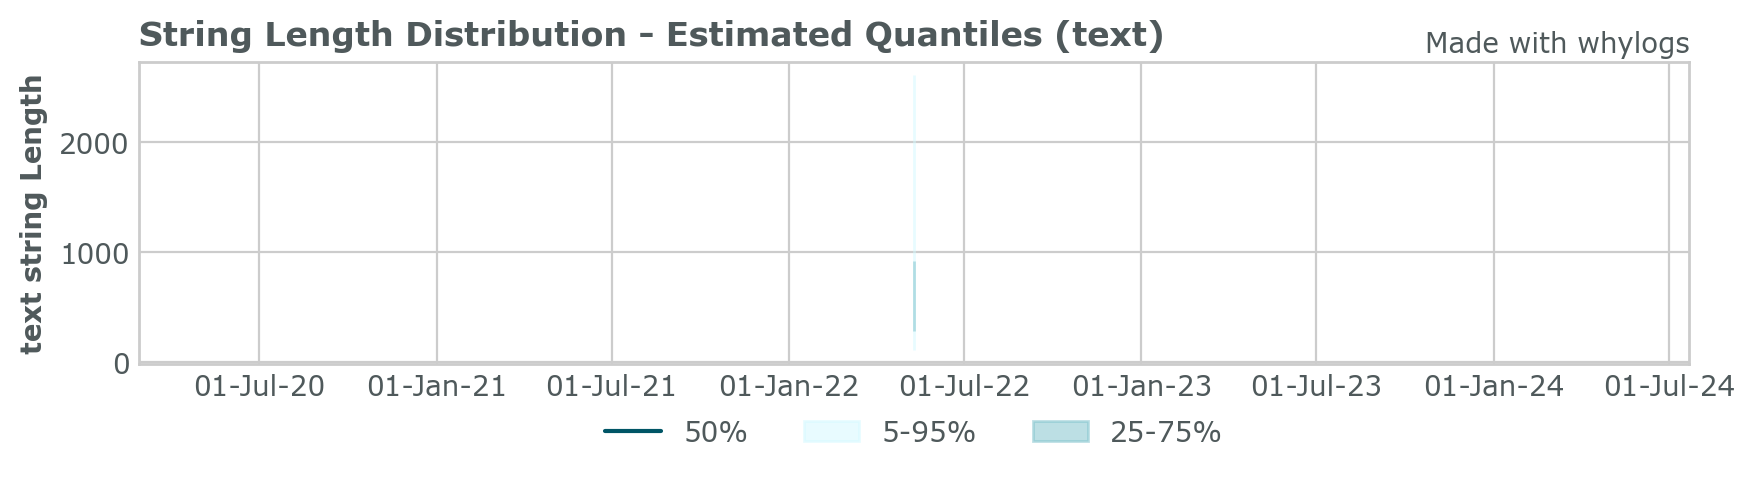

In [7]:
from whylogs.viz import ProfileVisualizer

profiles = [profile_1]
viz = ProfileVisualizer()
viz.set_profiles(profiles)
viz.plot_string_length("text")

# Another Example

To be passed into a model, text datasets need to be transformed into a numerical representation. This process is known as tokenization.

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding=False, truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\stuar\.cache\huggingface\datasets\yelp_review_full\yelp_review_full\1.0.0\e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf\cache-2d04b3cd45784c8a.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [9]:
# using the same seed
small_tokenized_train_dataset = tokenized_datasets["train"].shuffle(seed=777).select(range(100))

Loading cached shuffled indices for dataset at C:\Users\stuar\.cache\huggingface\datasets\yelp_review_full\yelp_review_full\1.0.0\e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf\cache-be6ca66345a7e1b4.arrow


In [10]:
len(small_train_dataset["text"][0]), len(small_tokenized_train_dataset["input_ids"][0])

(439, 108)

In [11]:
from whylogs import get_or_create_session

session = get_or_create_session()
with session.logger(dataset_name="tokenized_text_dataset") as logger:
    
    for review in range(len(small_tokenized_train_dataset)):
        logger.log({"text": small_tokenized_train_dataset["text"][review]})
    profile_2 = logger.profile

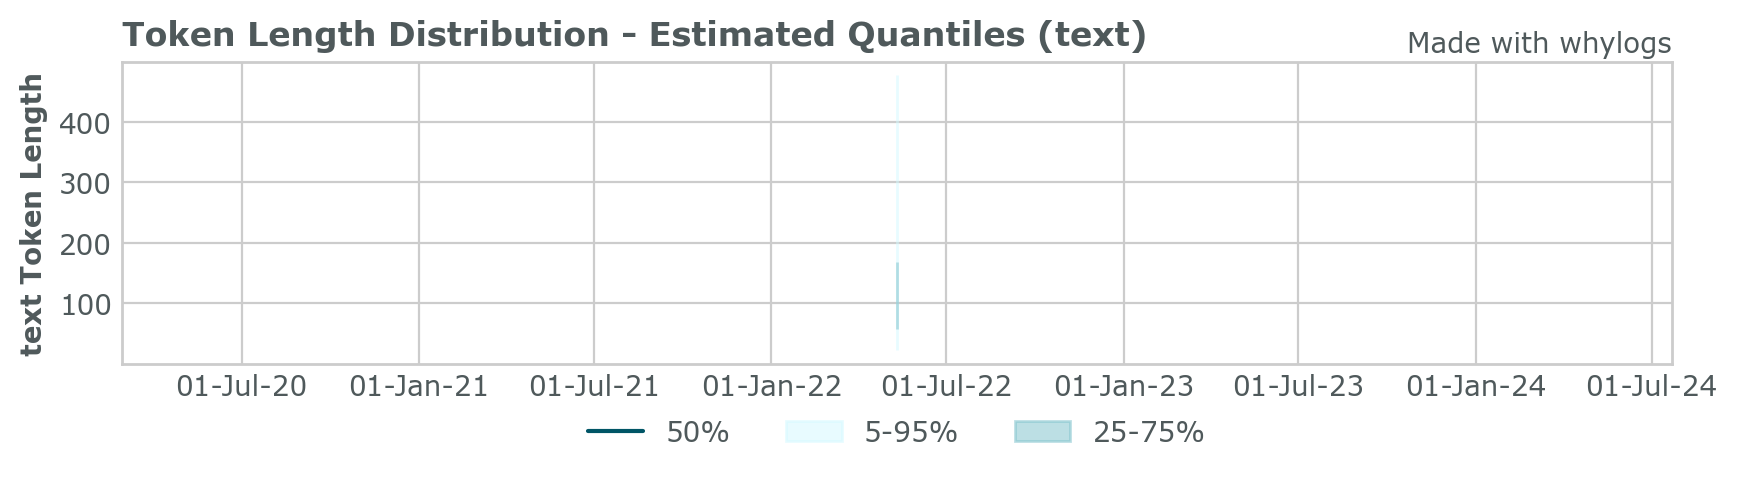

In [12]:
profiles = [profile_2]
viz = ProfileVisualizer()
viz.set_profiles(profiles)
viz.plot_token_length("text")